In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import random
from datetime import datetime

# Set the style & colors for the plots
sns.set_style('darkgrid')
_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Control randomness
random.seed(1)

# Prior specifications


## Prior 1: Prior odds

Prior belief about (relative) likelihoods of a Hypothesis being true:
$$
Posterior = \mathbf{Prior} \times BF
$$

$$
\frac{P(H_1| \text{Data})}{P(H_0| \text{Data})} = \frac{\mathbf{P(H_1)}}{\mathbf{P(H_0)}} \times \frac{P(\text{Data}| H_1)}{P(\text{Data}| H_0)}
$$



In [2]:
# Define Prior odds
prior_odds = 1

## Prior 2: Parameter priors

Prior belief about parameter distributions conditional on a Hypothesis being true. This component is located in the Bayes Factor (Marginal likelihood ratio)

$$
Posterior = Prior \times \mathbf{BF}
$$

$$
\frac{P(H_1| \text{Data})}{P(H_0| \text{Data})} = \frac{P(H_1)}{P(H_0)} \times \frac{\mathbf{P(\text{Data}| H_1)}}{\mathbf{P(\text{Data}| H_0)}}
$$

With:

$$
P(\text{Data}| H_0) = \int P(\text{Data}|\lambda, H_0) \mathbf{P(\lambda|H_0)} \, d\lambda
$$

Note: Marginal likelihood & likelihood not the same.



In [3]:
# Visualisation function for beta distribution
def plot_beta_distribution(T_alpha, T_beta, T_mean, C_alpha, C_beta, C_mean):
    # Generate values between 0 and 1 (these are the possible values of a Beta distribution)
    x = np.linspace(0, 1, 1000)

    # Calculate the value of the pdf for each x value
    C_dist = stats.beta.pdf(x, C_alpha, C_beta)
    T_dist = stats.beta.pdf(x, T_alpha, T_beta)

    # Plot distributions & means
    plt.plot(x, C_dist, label=f'Control: α={C_alpha}, β={C_beta} (mean: {C_mean})', color = _colors[0])
    plt.axvline(C_mean, color = _colors[0], linestyle = "--", alpha = 0.5)

    plt.plot(x, T_dist, label=f'Treatment: α={T_alpha}, β={T_beta} (mean: {T_mean})', color = _colors[1])
    plt.axvline(T_mean, color = _colors[1], linestyle = "--", alpha = 0.5)

    plt.title('Beta Distribution')
    plt.xlabel('x')
    plt.ylabel('pdf(x)')
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True)
    plt.show()

Specify prior parameters: $P(\lambda)$
- Helper function to transform tangible prior beliefs on effect magnitude & associated certainty to Beta distributions parameters

using helper function:


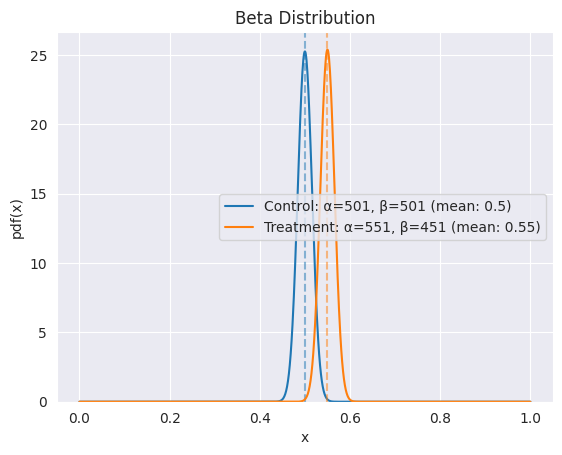

In [4]:
# Specify prior distribution (mean + "weight" as proxy for variance)
mean_C, weight_C = 0.5, 1000
mean_T, weight_T = 0.55, 1000

# Help function with determining alpha & beta
def beta_helper(prior_prob, weight):
    # Sample from Beta distribution: B(weight(prior belief) + 1, weight(1 - prior belief) + 1)
    a = round(prior_prob, 2) * weight + 1
    b = (1 - round(prior_prob, 2)) * weight + 1
    return round(a), round(b)

# parameters: Mean, weight
C_prior, T_prior = dict(), dict()
C_prior["alpha"], C_prior["beta"] = beta_helper(mean_C, weight_C)
T_prior["alpha"], T_prior["beta"] = beta_helper(mean_T, weight_T)

print("using helper function:")
plot_beta_distribution(T_prior["alpha"], T_prior["beta"], mean_T, C_prior["alpha"], C_prior["beta"], mean_C)

# Data Generating Process
- Specify Control & Treatment group: sample size & true conversion rate
- Bernoulli distribution (Binary outcome data)

In [5]:
# Define Control & Treatment DGP (Bernoulli distributed)
C = {"n": 100000, "true_prob": 0.5}
T = {"n": 100000, "true_prob": 0.55}

In [6]:
def get_bernoulli_sample(mean, n):
    # Sample bernoulli distribution with relevant metrics
    samples = [1 if random.random() < mean else 0 for _ in range(n)]
    converted = sum(samples)
    mean = converted/n

    return samples, converted, mean

C["sample"], C["converted"], C["sample_conversion_rate"] = get_bernoulli_sample(mean = C["true_prob"], n = C["n"])
T["sample"], T["converted"], T["sample_conversion_rate"] = get_bernoulli_sample(mean = T["true_prob"], n = T["n"])

# visualise data structure
print(f"Control: {C['sample'][:10]}, Conversion_Rate = {C['sample_conversion_rate']} (true = {C['true_prob']}) \nTreatment: {T['sample'][:10]}, Conversion_Rate = {T['sample_conversion_rate']} (true = {T['true_prob']})")


Control: [1, 0, 0, 1, 1, 1, 0, 0, 1, 1], Conversion_Rate = 0.5004 (true = 0.5) 
Treatment: [1, 0, 1, 1, 1, 1, 1, 1, 1, 1], Conversion_Rate = 0.54892 (true = 0.55)


# Evidence evaluation
- Effect estimation
- Quantifying level of certainty

---
## Beta-Binomial Marginal Likelihood
define (per group):
- Observations:
  - n (sample size)
  - c (nr of conversions)
- Prior (conditional on Hypothesis?):
  - $\alpha$
  - $\beta$

Marginal likelihood:
$$P[data|H] = \binom{N}{C}\frac{Beta(\alpha + c, \beta + (n - c)}{Beta(\alpha, \beta)}$$

Likelihood:
$$L(p; \mathbf{x}) = \prod_{i=1}^{n} p^{x_i} (1-p)^{1-x_i} = p^c(1 - p)^{n - c}$$

Marginal Likelihood distribution (?):
$$Beta(\alpha + c, \beta + (n - c)$$

---
**Current challenge:**
What are the marginal likelihoods that should be divided & which parameters do we put in there?



we have 6 options:
1. Treatment + H0 prior (no effect)
2. Treatment + H1 prior (effect)
3. Control + H0 prior (no effect)
4. Control + H1 prior (effect)
5. Treatment + point estimate H0 prior (no effect)
6. Treatment + point estimate H1 prior (effect)
7. Control + point estimate H0 prior (no effect)
8. Control + point estimate H1 prior (effect)

Intuitively I'd think either:
- 2 / 1 -> only considers T, checks whether it's more likely to belong to effect DGP or not
- 1 / 3 -> conditions on no effect prior and weight T vs C (seems like frequentist?)
- 2 / 5 -> Distributions of priors most accurately depict hypothesis design

Sanity check:
- 4 / 3 should strong favor H0 in presence of treatment

old approach:
- 6 / 5 compare likelihoods of hypotheses (point) for treatment only




Different variations of ways to compute (marginal) likelihood for Beta-binomial distributions

In [7]:
from math import comb
from scipy.special import beta as beta_function

import numpy as np
from scipy.special import gammaln

# Marginal likelihood (hypothesis: distribution)
def marginal_likelihood_1(prior_alpha, prior_beta, n, converted):
    # Beta distribution because prior Beta distribution is conjugate
    beta_posterior = stats.beta(prior_alpha + converted, prior_beta + (n - converted))
    samples = beta_posterior.rvs(size = 100_000)
    return samples

def marginal_likelihood_2(alpha, beta, n, converted):
    return comb(n, converted) * beta_function(converted + alpha, n - converted + beta) / beta_function(alpha, beta)

def marginal_likelihood_3(alpha, beta, n, converted): # via log (maybe necessary if n too large)
    # Log transformation of marginal likelihood function
    log_comb = gammaln(n+1) - gammaln(converted+1) - gammaln(n-converted+1)
    log_beta1 = gammaln(converted + alpha) + gammaln(n - converted + beta) - gammaln(n + alpha + beta)
    log_beta2 = gammaln(alpha) + gammaln(beta) - gammaln(alpha + beta)
    log_result = log_comb + log_beta1 - log_beta2
    return np.exp(log_result)


def bernoulli_likelihood(hypothesis_mean, converted, n):
    # Bernoulli likelihood (through log to avoid exploding values)
    log_conversions = converted * np.log(hypothesis_mean)
    log_non_conversions = (n - converted) * np.log(1 - hypothesis_mean)
    log_likelihood = log_conversions + log_non_conversions
    return log_likelihood


In [8]:
# Input data
c1 = [C_prior["alpha"], C_prior["beta"], T["n"], T["converted"]] # T + H0 (C prior)
c2 = [T_prior["alpha"], T_prior["beta"], T["n"], T["converted"]] # T + H1 (T prior)
c3 = [C_prior["alpha"], C_prior["beta"], C["n"], C["converted"]] # C + H0 (C prior)
c4 = [T_prior["alpha"], T_prior["beta"], C["n"], C["converted"]] # C + H1 (T prior)

# Calculate BF
numerator = marginal_likelihood_3(*c2)
denominator = marginal_likelihood_3(*c1)
bayes_factor = numerator / denominator

print("BF:", round(bayes_factor, 3))

BF: 117.23


In [21]:
# idea: https://chat.openai.com/share/6a6bbec6-cbd6-4a24-8289-29872da3ee03
from scipy.special import betaln

def compute_log_bayes_factor(alpha_0, beta_0, alpha_t, beta_t, alpha_c, beta_c, s_t, n_t, s_c, n_c):
    # Log probability of data under H0
    log_prob_data_H0 = betaln(alpha_0 + s_t + s_c, beta_0 + n_t + n_c - s_t - s_c) - betaln(alpha_0, beta_0)

    # Log probability of data under H1 for treatment group
    log_prob_data_H1_treatment = betaln(alpha_t + s_t, beta_t + n_t - s_t) - betaln(alpha_t, beta_t)

    # Log probability of data under H1 for control group
    log_prob_data_H1_control = betaln(alpha_c + s_c, beta_c + n_c - s_c) - betaln(alpha_c, beta_c)

    # Log joint probability of data under H1
    log_prob_data_H1 = log_prob_data_H1_treatment + log_prob_data_H1_control

    # Compute Log Bayes Factor
    log_BF_10 = log_prob_data_H1 - log_prob_data_H0
    bf_10 = np.exp(log_BF_10)

    return bf_10

# Example usage:
alpha_0, beta_0 = C_prior["alpha"], C_prior["beta"]
alpha_t, beta_t = T_prior["alpha"], T_prior["beta"]
alpha_c, beta_c = C_prior["alpha"], C_prior["beta"]
s_t, n_t = T["converted"], T["n"]  # Successes and total observations for treatment group
s_c, n_c = C["converted"], C["n"]  # Successes and total observations for control group

BF_10 = compute_log_bayes_factor(alpha_0, beta_0, alpha_t, beta_t, alpha_c, beta_c, s_t, n_t, s_c, n_c)
print(f"Bayes Factor (BF_10) = {BF_10}")


Bayes Factor (BF_10) = 1.6014438939676447e+102


In [9]:
c5 = [mean_C, T["converted"], T["n"]] # T + prior H0
c6 = [mean_T, T["converted"], T["n"]] # T + prior H1
c7 = [mean_C, C["converted"], C["n"]] # C + prior H0
c8 = [mean_T, C["converted"], C["n"]] # C + prior H1

# Calculate BF
numerator_log_likelihood = bernoulli_likelihood(*c6)
denominator_log_likelihood = bernoulli_likelihood(*c5)
bayes_factor_old = np.exp(numerator_log_likelihood - denominator_log_likelihood)

print("\nBF (old & likely wrong):", round(bayes_factor_old, 3))


BF (old & likely wrong): 1.2542655510724853e+208


[501, 501, 100000, 54892] [551, 451, 100000, 54892]


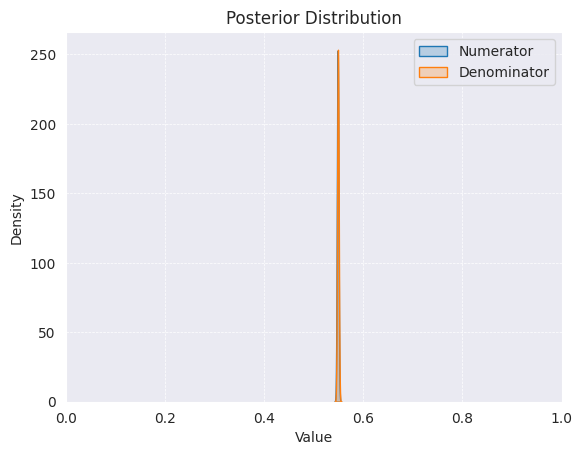

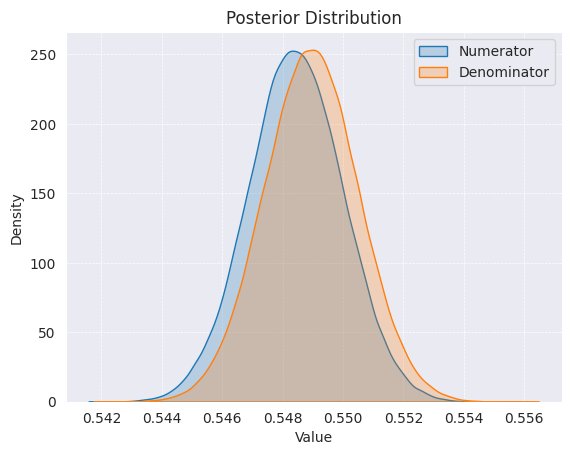

In [10]:
# Generate the samples
samples_numerator = marginal_likelihood_1(*c1)
samples_denominator = marginal_likelihood_1(*c2)

print(c1, c2)

# Plotting the distribution of the samples
sns.kdeplot(samples_numerator, fill = True, label = "Numerator")
sns.kdeplot(samples_denominator, fill = True, label = "Denominator")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(0,1)
plt.title("Posterior Distribution")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# Plotting the distribution of the samples
sns.kdeplot(samples_numerator, fill = True, label = "Numerator")
sns.kdeplot(samples_denominator, fill = True, label = "Denominator")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Posterior Distribution")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [11]:
post_odds = prior_odds * bayes_factor
